In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_csv('xbtusd_4H.csv')
df

,T,O,H,L,C,V
0,2015-09-25 12:00:00,239.99,239.99,236.08,236.34,51560
1,2015-09-25 16:00:00,236.34,236.21,235.44,236.10,102126
2,2015-09-25 20:00:00,236.10,236.12,234.81,235.18,33254
3,2015-09-26 00:00:00,235.18,235.36,234.90,234.90,5351
4,2015-09-26 04:00:00,234.90,235.11,233.30,234.17,17024
...,...,...,...,...,...,...
11784,2021-02-09 12:00:00,45730.00,46860.00,45073.50,46709.00,747788491
11785,2021-02-09 16:00:00,46709.00,47468.00,46046.00,47069.50,543384249
11786,2021-02-09 20:00:00,47069.50,47630.50,46520.00,46917.00,340348908
11787,2021-02-10 00:00:00,46917.00,46955.50,46070.00,46406.50,304709416


## ema form close price

In [3]:
df['ema12'] = df['C'].ewm(span=12, adjust=False).mean()
df['ema26'] = df['C'].ewm(span=26, adjust=False).mean()

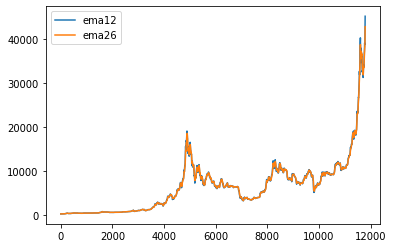

In [4]:
# plt.plot(df['C'], label='C')
plt.plot(df['ema12'], label='ema12')
plt.plot(df['ema26'], label='ema26')
plt.legend(loc=2)

## mark point ema12, 26 cross

In [41]:
df['Buy'] = np.where( (df['ema12']> df['ema26']), 1, 0) #ถ้า ema 12 > 26 ใช่ 1 ไม่ใช่ 0
df['Sell'] = np.where( (df['ema12']< df['ema26']), 1, 0)

KeyError: 'ema12'

In [6]:
df = df.drop(columns=['O', 'H', 'L', 'V'])

In [7]:
df['Buy_ind'] = np.where( (df['Buy'] > df['Buy'].shift(1)),1,0) #ถ้าเจอ 1 ซ้ำติดกัน2ตัวขึ้นไป ให้เปลี่ยนเป็น 0
df['Sell_ind'] = np.where( (df['Sell'] > df['Sell'].shift(1)),1,0)

In [8]:
df["Buy_ind"].replace({1: "long"}, inplace=True) #เปลี่ยนชื่อ
df["Sell_ind"].replace({1: "short"}, inplace=True)

In [9]:
df['Sell_ind'].replace(0, np.nan, inplace=True)
df['Buy_ind'].replace(0, np.nan, inplace=True)

In [10]:
df['signal'] = df["Buy_ind"].combine_first(df["Sell_ind"]) #รวม short long เป็น column ตัวกัน

In [11]:
df['signal'].value_counts()

short    163
long     163
Name: signal, dtype: int64

In [12]:
df["signal"].fillna('0', inplace = True)

In [13]:
df = df.drop(columns=['Buy', 'Sell', 'Buy_ind', 'Sell_ind'])

In [14]:
df = df.loc[(df['signal'] == 'short') | (df['signal'] == 'long')]
df

,T,C,ema12,ema26,signal
1,2015-09-25 16:00:00,236.10,236.303077,236.322222,short
17,2015-09-28 08:00:00,239.16,235.369263,235.329196,long
254,2015-11-06 20:00:00,380.19,392.534007,393.002233,short
320,2015-11-17 20:00:00,338.53,333.257999,333.076917,long
331,2015-11-19 16:00:00,329.37,332.840667,333.147807,short
...,...,...,...,...,...
11627,2021-01-14 08:00:00,38534.00,36283.738081,36155.184012,long
11642,2021-01-16 20:00:00,36119.50,36846.601665,36849.100872,short
11657,2021-01-19 08:00:00,37130.00,36404.798427,36386.761751,long
11662,2021-01-20 04:00:00,35255.00,36267.327333,36338.569647,short


In [15]:
# df.to_csv(r'C:\Users\sangh\Documents\bitmex_history\easy-data-scripts\backtest\singnal_4h.csv', index = False, header=True)

## calculate and plot graph signal

In [16]:
df = df.reset_index()

In [17]:
df = df.drop(columns=['index', 'ema12', 'ema26'])

In [18]:
#price short inverse
entry_value = 1/df[df.index % 2 == 0]['C']
exit_value = 1/df[df.index % 2 == 1]['C']
entry_value = entry_value.reset_index()
entry_value = entry_value.drop(columns=['index'])
exit_value = exit_value.reset_index()
exit_value = exit_value.drop(columns=['index'])
profit = entry_value-exit_value
roe_short = (profit/entry_value)*100*-1
roe_short['total'] = roe_short.cumsum()

Profit short inverse
leverage = 1, quantity = 1
ROE max : 52.46
ROE min : -15.12
ROE mean : 0.82
ROE total : 133.96


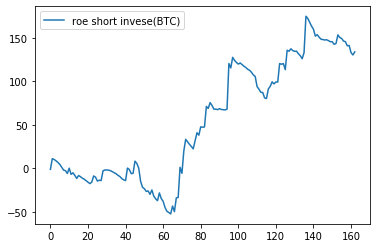

In [19]:
print('Profit short inverse')
print('leverage = 1, quantity = 1')
print('ROE max : %.2f' % (roe_short.max().iloc[0]))
print('ROE min : %.2f' % (roe_short.min().iloc[0]))
print('ROE mean : %.2f' % (roe_short.mean().iloc[0]))
print('ROE total : %.2f' % (roe_short.sum().iloc[0]))
plt.plot(roe_short['total'], label='roe short invese(BTC)')
plt.legend()

In [20]:
#price long inverse
entry_value = 1/df[df.index % 2 == 1]['C']
exit_value = 1/df[df.index % 2 == 0]['C']
entry_value = entry_value.reset_index()
entry_value = entry_value.drop(columns=['index'])
entry_value = entry_value.drop(index=162)

exit_value = exit_value.drop(index=0)
exit_value = exit_value.reset_index()
exit_value = exit_value.drop(columns=['index'])
profit = entry_value-exit_value
roe_long = profit/entry_value*100
roe_long['total'] = roe_long.cumsum()

Profit long inverse
leverage = 1, quantity = 1
ROE max : 60.16
ROE min : -14.19
ROE mean : 2.76
ROE total : 446.73


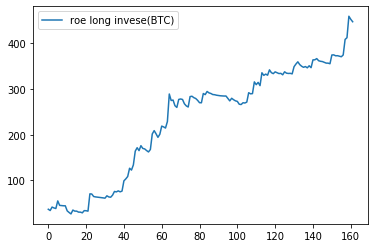

In [21]:
print('Profit long inverse')
print('leverage = 1, quantity = 1')
print('ROE max : %.2f' % (roe_long.max().iloc[0]))
print('ROE min : %.2f' % (roe_long.min().iloc[0]))
print('ROE mean : %.2f' % (roe_long.mean().iloc[0]))
print('ROE total : %.2f' % (roe_long.sum().iloc[0]))
plt.plot(roe_long['total'], label='roe long invese(BTC)')
plt.legend()

In [22]:
#price short normal
entry_value = df[df.index % 2 == 0]['C']
exit_value = df[df.index % 2 == 1]['C']

entry_value = entry_value.reset_index()
entry_value = entry_value.drop(columns=['index'])

exit_value = exit_value.reset_index()
exit_value = exit_value.drop(columns=['index'])

profit = entry_value-exit_value
roe_short_nm = (profit/entry_value)*100*-1
roe_short_nm['total'] = roe_short_nm.cumsum()

Profit long inverse
leverage = 1, quantity = 1
ROE max : 17.82
ROE min : -34.41
ROE mean : -0.25
ROE total : -40.89


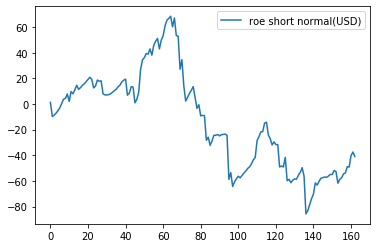

In [23]:
print('Profit long inverse')
print('leverage = 1, quantity = 1')
print('ROE max : %.2f' % (roe_short_nm.max().iloc[0]))
print('ROE min : %.2f' % (roe_short_nm.min().iloc[0]))
print('ROE mean : %.2f' % (roe_short_nm.mean().iloc[0]))
print('ROE total : %.2f' % (roe_short_nm.sum().iloc[0]))
plt.plot(roe_short_nm['total'], label='roe short normal(USD)')
plt.legend()

In [24]:
#price long normal
entry_price = df[df.index % 2 == 1]['C']
exit_price = df[df.index % 2 == 0]['C']

entry_price = entry_price.reset_index()
entry_price = entry_price.drop(columns=['index'])
entry_price = entry_price.drop(index=162)

exit_price = exit_price.drop(index=0)
exit_price = exit_price.reset_index()
exit_price = exit_price.drop(columns=['index'])
profit = exit_price-entry_price
roe_long_nm = (profit/entry_price)*100
roe_long_nm['total'] = roe_long_nm.cumsum()

Profit long normal
leverage = 1, quantity = 1
ROE max : 151.01
ROE min : -12.43
ROE mean : 4.76
ROE total : 770.72


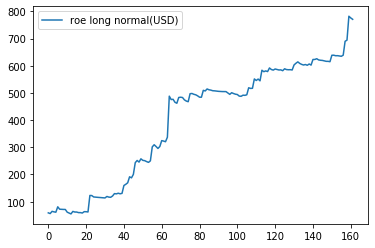

In [25]:
print('Profit long normal')
print('leverage = 1, quantity = 1')
print('ROE max : %.2f' % (roe_long_nm.max().iloc[0]))
print('ROE min : %.2f' % (roe_long_nm.min().iloc[0]))
print('ROE mean : %.2f' % (roe_long_nm.mean().iloc[0]))
print('ROE total : %.2f' % (roe_long_nm.sum().iloc[0]))
plt.plot(roe_long_nm['total'], label='roe long normal(USD)')
plt.legend()

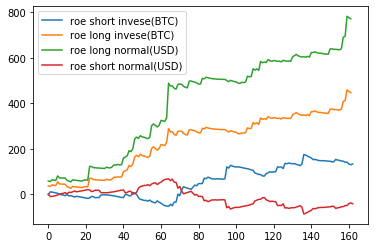

In [26]:
plt.plot(roe_short['total'], label='roe short invese(BTC)')
plt.plot(roe_long['total'], label='roe long invese(BTC)')
plt.plot(roe_long_nm['total'], label='roe long normal(USD)')
plt.plot(roe_short_nm['total'], label='roe short normal(USD)')
plt.legend()

In [39]:
roe_per_year = roe_long['C'].sum() + roe_short['C'].sum()
print('roe total 4 year 10 month : %.2f%%' % (roe_per_year))
print('roe avg per year : %.2f%%' % (roe_per_year/4.8))

roe total 4 year 10 month : 580.69%
roe avg per year : 120.98%


In [29]:
df

,T,C,signal
0,2015-09-25 16:00:00,236.10,short
1,2015-09-28 08:00:00,239.16,long
2,2015-11-06 20:00:00,380.19,short
3,2015-11-17 20:00:00,338.53,long
4,2015-11-19 16:00:00,329.37,short
...,...,...,...
321,2021-01-14 08:00:00,38534.00,long
322,2021-01-16 20:00:00,36119.50,short
323,2021-01-19 08:00:00,37130.00,long
324,2021-01-20 04:00:00,35255.00,short
